In [1]:
import numpy as np 
import pandas as pd 
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import os
import sklearn
import tensorflow as tf
from tensorflow import keras

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, Input
from keras.layers import Conv2D, Activation, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.resnet50 import preprocess_input, ResNet50
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv('../input/data/Data_Entry_2017.csv')
image_path = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input/data/', 'images*', '*', '*.png'))}
data["path"] = data['Image Index'].map(image_path.get)
display(data.head(5))

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,../input/data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,../input/data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,../input/data/images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,../input/data/images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,../input/data/images_001/images/00000003_000.png


In [4]:
# Total number of entries 
print(len(data))
# Total number of image_path
print(len(image_path))

112120
112120


In [5]:
display(data.groupby('Finding Labels')['Image Index'].count().sort_values(ascending=False).head(100))

Finding Labels
No Finding                                              60361
Infiltration                                             9547
Atelectasis                                              4215
Effusion                                                 3955
Nodule                                                   2705
                                                        ...  
Consolidation|Infiltration|Mass                            42
Effusion|Infiltration|Pneumonia                            42
Atelectasis|Effusion|Infiltration|Pleural_Thickening       41
Cardiomegaly|Consolidation                                 40
Atelectasis|Emphysema|Infiltration                         39
Name: Image Index, Length: 100, dtype: int64

Finding Labels
No Finding                  60361
Infiltration                 9547
Atelectasis                  4215
Effusion                     3955
Nodule                       2705
Pneumothorax                 2194
Mass                         2139
Effusion|Infiltration        1603
Atelectasis|Infiltration     1350
Consolidation                1310
Name: Image Index, dtype: int64

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <a list of 10 Text major ticklabel objects>)

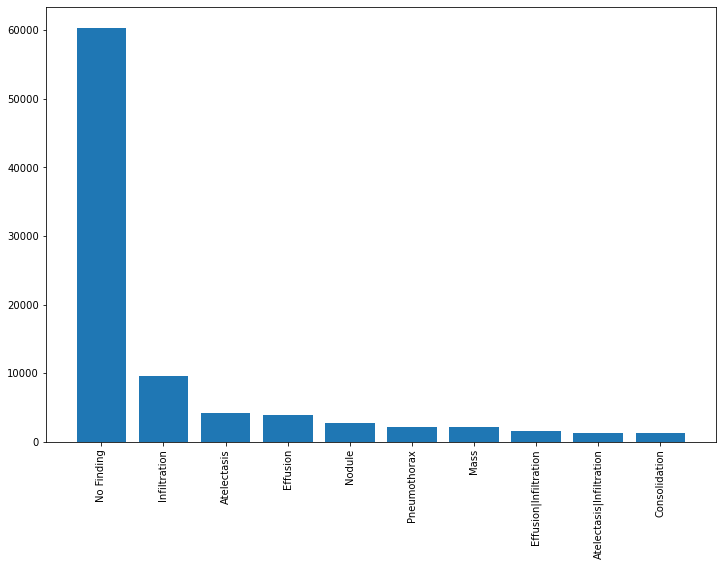

In [6]:
# Top 10 labels in the dataset 
disease_counts = data.groupby('Finding Labels')['Image Index'].count().sort_values(ascending=False).iloc[:10]
display(disease_counts)

# plotting top 10 labels' count
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(disease_counts))+0.5, disease_counts, tick_label=disease_counts.index)
plt.xticks(rotation=90)

**Conclusion the dataset is highly biased towards no finding so if even if we predict every time "No finding" then we still have high accuracy**

**We are dealing with multilabel multiclass classification**

Ideas
1. Can we create multiple instances for multilabel instances ?
1. Total classes = 15 (14 diseases and one No Finding)
1. Is there superimposition of diseases like if we have A disease and B disease can our X ray show both of them, or one can influence or hide the other or their combination lead to a new xray image not similar to either of them.
1. Will we be using features like age or patient gender to predict the diseases ? or just image ?

First some preprocessing of labels and features is required.

In [7]:
data['Finding Labels'] = data['Finding Labels'].map(lambda x: x.replace('No Finding','Nothing'))

from itertools import chain
labels = np.unique(list(chain(*data['Finding Labels'].map(lambda x: x.split('|')).tolist())))
display(labels)

array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'Nodule', 'Nothing', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'], dtype='<U18')

In [8]:
# Create a sort of one hot encoding for each instances labels
# Remember multiclass multilabel classification
for lbl in labels: 
    data[lbl] = data['Finding Labels'].map(lambda find: 1 if lbl in find else 0)
data['encoding'] = [[1 if l in lbl.split('|') else 0 for l in labels] for lbl in data['Finding Labels']]
display(data[['encoding','Finding Labels']])

,encoding,Finding Labels
0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",Cardiomegaly
1,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",Cardiomegaly|Emphysema
2,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",Cardiomegaly|Effusion
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",Nothing
4,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",Hernia
...,...,...
112115,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]",Mass|Pneumonia
112116,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",Nothing
112117,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",Nothing
112118,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",Nothing


We created one hot encoding with respect to every image given and its finding label. Now we will calculate class count with respect to every label and since No Finding( Nothing) has more than 50% of share in Training set. We will calculate class weightage = (1/ class count) with respect to every label

In [9]:
class_count = {}
for lbl in labels:
    class_count[lbl] = data[lbl].sum()

classweight = {}
for lbl in labels :
    classweight[lbl] = 1/class_count[lbl]

#classweight['Nothing'] /= 2   #Extra penalising the none class 
def func(row):
    weight = 0
    for lbl in labels: 
        if(row[lbl]==1):
            weight += classweight[lbl]
    return weight
new_weights = data.apply(func, axis=1)
display(new_weights)

0         0.000360
1         0.000758
2         0.000435
3         0.000017
4         0.004405
            ...   
112115    0.000872
112116    0.000017
112117    0.000017
112118    0.000017
112119    0.000017
Length: 112120, dtype: float64

In [10]:
sampled_data = data.sample(40000, weights = new_weights)

Finding Labels
Nothing                              6173
Infiltration                         2685
Atelectasis                          1830
Nodule                               1765
Pneumothorax                         1587
Effusion                             1538
Mass                                 1444
Consolidation                         995
Cardiomegaly                          990
Pleural_Thickening                    963
Effusion|Infiltration                 892
Emphysema                             811
Atelectasis|Infiltration              770
Atelectasis|Effusion                  758
Fibrosis                              713
Infiltration|Nodule                   613
Edema                                 596
Atelectasis|Effusion|Infiltration     550
Cardiomegaly|Effusion                 456
Edema|Infiltration                    381
Name: Image Index, dtype: int64

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]),
 <a list of 20 Text major ticklabel objects>)

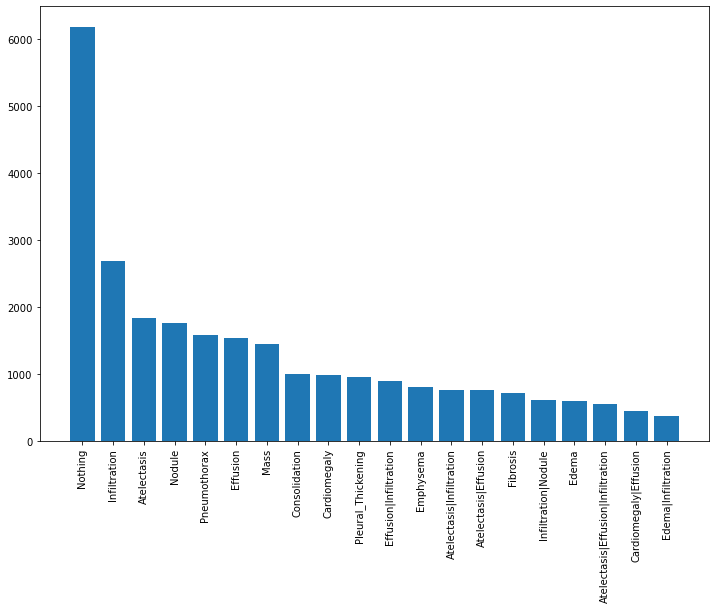

In [11]:
# Top 20 labels in the dataset 
disease_counts = sampled_data.groupby('Finding Labels')['Image Index'].count().sort_values(ascending=False).iloc[:20]
display(disease_counts)
# plotting top 10 labels' count
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(disease_counts))+0.5, disease_counts, tick_label=disease_counts.index)
plt.xticks(rotation=90)

In [12]:
class_count1={}
for lbl in labels:
    class_count1[lbl] = sampled_data[lbl].sum()
display(class_count1)



{'Atelectasis': 7691,
 'Cardiomegaly': 2613,
 'Consolidation': 4083,
 'Edema': 2239,
 'Effusion': 9086,
 'Emphysema': 2402,
 'Fibrosis': 1665,
 'Hernia': 227,
 'Infiltration': 10877,
 'Mass': 4696,
 'Nodule': 4916,
 'Nothing': 6173,
 'Pleural_Thickening': 3122,
 'Pneumonia': 1423,
 'Pneumothorax': 4412}

In [13]:
len(class_count1)

15

,Count
Infiltration,10877
Effusion,9086
Atelectasis,7691
Nothing,6173
Nodule,4916
Mass,4696
Pneumothorax,4412
Consolidation,4083
Pleural_Thickening,3122
Cardiomegaly,2613


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

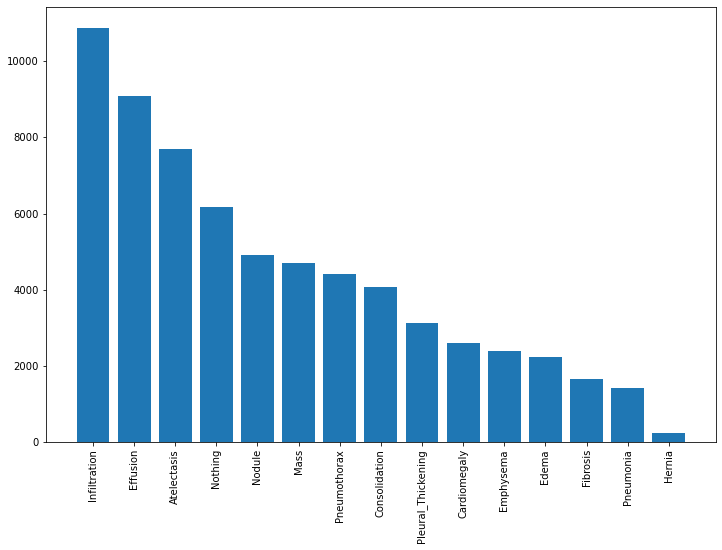

In [14]:
classpd = pd.DataFrame(class_count1, index = ['Count'])
classpd = classpd.transpose()
classpd = classpd.sort_values("Count",ascending=False)
display(classpd)

plt.figure(figsize=(12,8))
plt.bar(np.arange(len(classpd)), classpd['Count'], tick_label=classpd.index)
plt.xticks(rotation=90)

Significant improvement in the dataset by removing a lot of biasness from the data,

In [15]:
# Getting train and test data
from sklearn.model_selection import train_test_split
train_data , test_data = train_test_split(sampled_data, test_size=0.2)
train_data , valid_data = train_test_split(train_data, test_size=0.25)
print(len(train_data))
print(len(test_data))
print(len(valid_data))

24000
8000
8000


Creating ImageDataGenerators


In [16]:
from keras.preprocessing.image import ImageDataGenerator 
IMG_SIZE = (299, 299)
# core imagedatagenerator used to create train and test imageDatagenerators
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [17]:
valid_data['newLabel'] = valid_data.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
train_data['newLabel'] = train_data.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
test_data['newLabel'] = test_data.apply(lambda x: x['Finding Labels'].split('|'), axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
train_gen = core_idg.flow_from_dataframe(
    dataframe=train_data,
    directory=None,
    x_col = 'path',
    y_col = 'newLabel',
    class_mode = 'categorical',
    target_size = IMG_SIZE,
    color_mode = 'rgb',
    batch_size = 32)

valid_gen = core_idg.flow_from_dataframe(
    dataframe=valid_data,
    directory=None,
    x_col = 'path',
    y_col = 'newLabel',
    class_mode = 'categorical',
    target_size = IMG_SIZE,
    color_mode = 'rgb',
    batch_size = 256) # we can use much larger batches for evaluation

test_X, test_Y = next(core_idg.flow_from_dataframe(
    dataframe=valid_data,
    directory=None,
    x_col = 'path',
    y_col = 'newLabel',
    class_mode = 'categorical',
    target_size = IMG_SIZE,
    color_mode = 'rgb',
    batch_size = 1024))

Found 24000 validated image filenames belonging to 15 classes.
Found 8000 validated image filenames belonging to 15 classes.
Found 8000 validated image filenames belonging to 15 classes.


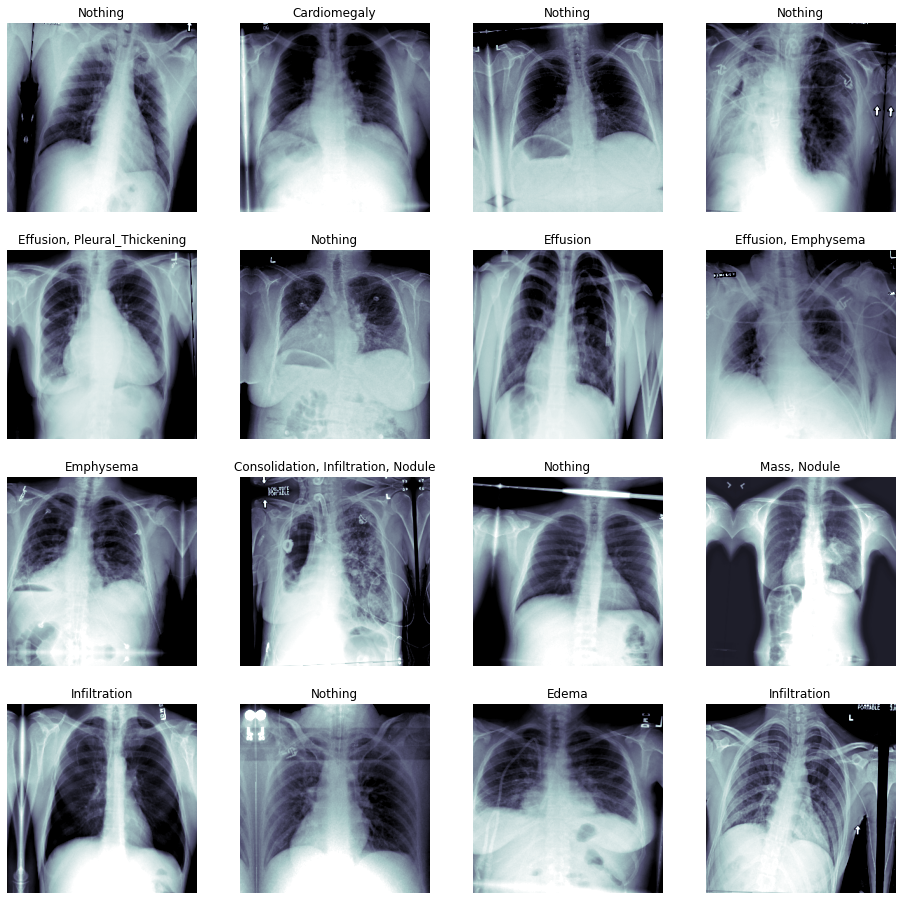

In [19]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

In [23]:
# transfer learning on Xception
base_model = keras.applications.xception.Xception(include_top=False, weights='imagenet')

In [24]:
# completing the model
n_classes = len(labels)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation='sigmoid')(avg)
model = keras.Model(inputs=base_model.inputs, outputs = output)

In [26]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

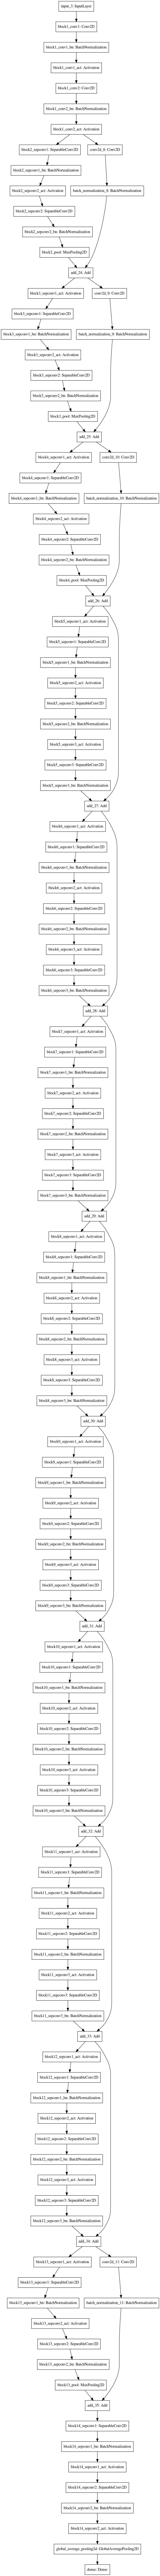

In [27]:
keras.utils.plot_model(model)

In [28]:
met = ['categorical_accuracy', keras.metrics.Precision(), keras.metrics.AUC(), 'binary_accuracy']

In [29]:
for layer in base_model.layers:
    layer.trainable = False
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01), metrics=met)
history = model.fit_generator(train_gen, steps_per_epoch=100, validation_data=(test_X, test_Y), epochs=1,max_queue_size=100, workers=-1, use_multiprocessing=True)

100/100 [==============================] - 171s 2s/step - loss: 0.3444 - categorical_accuracy: 0.1519 - precision: 0.1950 - auc: 0.6853 - binary_accuracy: 0.8829 - val_loss: 0.3209 - val_categorical_accuracy: 0.1621 - val_precision: 0.5000 - val_auc: 0.7170 - val_binary_accuracy: 0.8898


In [30]:
model.save('Xception.h5')

In [ ]:
#model = keras.models.load_model('/kaggle/input/nihmodelset/Xception (2).h5')

for layer in base_model.layers:
    layer.trainable = True
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=met)
history = model.fit_generator(train_gen, steps_per_epoch=100, validation_data=(test_X, test_Y), epochs=3,max_queue_size=100, workers=-1, use_multiprocessing=True)